機械学習手法（Lasso, Ridge, サポートベクターマシン, ランダムフォレスト、ブースティング木、XGBoost、LightGBM）の使用例。

参考：https://code-examples.net/ja/docs/scikit_learn/modules/cross_validation

参考：https://qiita.com/nazoking@github/items/1c5106a844084cd8539a

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn import linear_model
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import lightgbm as lgb

### インプットデータファイル。

In [2]:
risk_df = pd.read_csv('chsi_dataset/RISKFACTORSANDACCESSTOCARE.csv')
death_df = pd.read_csv('chsi_dataset/SUMMARYMEASURESOFHEALTH.csv')

death_df = death_df[["All_Death"]]

df = pd.concat([risk_df, death_df], axis=1)
df.head(10)

,State_FIPS_Code,County_FIPS_Code,CHSI_County_Name,CHSI_State_Name,CHSI_State_Abbr,Strata_ID_Number,No_Exercise,CI_Min_No_Exercise,CI_Max_No_Exercise,Few_Fruit_Veg,...,CI_Min_Diabetes,CI_Max_Diabetes,Uninsured,Elderly_Medicare,Disabled_Medicare,Prim_Care_Phys_Rate,Dentist_Rate,Community_Health_Center_Ind,HPSA_Ind,All_Death
0,1,1,Autauga,Alabama,AL,29,27.8,20.7,34.9,78.6,...,9.1,19.3,5690,4762,1209,45.3,22.6,1,2,1041.5
1,1,3,Baldwin,Alabama,AL,16,27.2,23.2,31.2,76.2,...,5.2,9.3,19798,22635,3839,67.0,30.8,1,2,856.9
2,1,5,Barbour,Alabama,AL,51,-1111.1,-1111.1,-1111.1,-1111.1,...,2.0,11.3,5126,3288,1092,45.8,24.6,1,2,1019.4
3,1,7,Bibb,Alabama,AL,42,-1111.1,-1111.1,-1111.1,86.6,...,4.7,21.5,3315,2390,974,41.8,18.6,1,1,1050.5
4,1,9,Blount,Alabama,AL,28,33.5,26.3,40.6,74.6,...,4.4,12.4,8131,5019,1300,16.2,10.8,2,1,954.2
5,1,11,Bullock,Alabama,AL,75,-1111.1,-1111.1,-1111.1,-1111.1,...,-1111.1,-1111.1,2295,1433,504,54.3,18.1,1,1,1107.6
6,1,13,Butler,Alabama,AL,76,24.5,15.5,33.5,-1111.1,...,4.4,14.6,4055,3150,952,43.3,19.3,1,2,1084.2
7,1,15,Calhoun,Alabama,AL,6,29.2,25.1,33.3,81.9,...,8.4,13.9,16456,16440,5301,75.8,41.9,1,2,1100.3
8,1,17,Chambers,Alabama,AL,50,34.7,25.3,44.0,84.6,...,10.2,24.1,5533,5473,1497,53.6,22.6,1,2,1075.6
9,1,19,Cherokee,Alabama,AL,64,-1111.1,-1111.1,-1111.1,-1111.1,...,6.8,19.8,3583,3086,854,28.5,12.2,2,1,999.3


In [41]:
df = df.replace(-1111.1, np.nan)
df.isnull().apply(lambda col: col.value_counts(), axis=0).fillna(0).astype(np.float).apply(lambda col: col/col.sum(), axis=0)

,State_FIPS_Code,County_FIPS_Code,CHSI_County_Name,CHSI_State_Name,CHSI_State_Abbr,Strata_ID_Number,No_Exercise,CI_Min_No_Exercise,CI_Max_No_Exercise,Few_Fruit_Veg,...,CI_Min_Diabetes,CI_Max_Diabetes,Uninsured,Elderly_Medicare,Disabled_Medicare,Prim_Care_Phys_Rate,Dentist_Rate,Community_Health_Center_Ind,HPSA_Ind,All_Death
False,1.0,1.0,1.0,1.0,1.0,1.0,0.702324,0.702324,0.702324,0.606176,...,0.865648,0.865648,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999363
True,0.0,0.0,0.0,0.0,0.0,0.0,0.297676,0.297676,0.297676,0.393824,...,0.134352,0.134352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000637


In [42]:
# df = df.fillna(df.median())
print(df.shape)
df = df.dropna()
print(df.shape)

df_test  = df[df['CHSI_State_Name'].isin(['Michigan', 'Wisconsin','Ohio', 'Indiana', 'Illinois', 'Wisconsin'])]
df_train = df[~df['CHSI_State_Name'].isin(['Michigan', 'Wisconsin','Ohio', 'Indiana', 'Illinois', 'Wisconsin'])]

X = df[["Smoker",
        "Obesity",
        "No_Exercise",
        "Few_Fruit_Veg",
        "High_Blood_Pres",
        "Diabetes"]].values

y = df[["All_Death"]].values
y = np.reshape(y,(-1)) # ←yを1次元配列に変換するために必要。

(3141, 32)
(1434, 32)


In [5]:
df['CHSI_State_Name'].value_counts()

Iowa                    73
Kentucky                58
South Dakota            51
Oklahoma                49
North Carolina          48
Virginia                44
Georgia                 42
Pennsylvania            41
Indiana                 40
Louisiana               39
Wisconsin               38
Florida                 38
Tennessee               35
Missouri                35
Nebraska                34
Idaho                   34
New York                34
South Carolina          34
Michigan                33
Minnesota               33
Mississippi             32
West Virginia           32
Texas                   32
Arkansas                32
Washington              31
Montana                 31
Kansas                  30
California              28
Ohio                    28
North Dakota            27
Illinois                25
Oregon                  25
New Mexico              24
Alabama                 23
Wyoming                 23
Maryland                22
New Jersey              21
U

### trainデータとtestデータ

In [6]:
X_train = df_train[["Smoker", "Obesity", "No_Exercise", "Few_Fruit_Veg", "High_Blood_Pres", "Diabetes"]].values
X_test  =  df_test[["Smoker", "Obesity", "No_Exercise", "Few_Fruit_Veg", "High_Blood_Pres", "Diabetes"]].values
y_train = df_train[["All_Death"]].values
y_test  =  df_test[["All_Death"]].values

y_train = np.reshape(y_train,(-1))
y_test = np.reshape(y_test,(-1)) # ←yを1次元配列に変換するために必要。

### クロスバリデーションにおける分割方法の指定。

In [7]:
kfold_cv = KFold(n_splits=5, random_state=0, shuffle=True)

# 各機械学習手法を実行
Lasso, Ridge, サポートベクターマシン, ランダムフォレスト、ブースティング木、XGBoost、LightGBM

ただしXGBoostはpipによる簡単なインストールができないので、使えるようにするためには下記書籍に記載されているような面倒な作業が必要。
https://www.amazon.co.jp/dp/4254275838

#### 基本的にはGridSearchCVでクロスバリデーションを実行。候補の中から最適なハイパーパラメータを選択。
参考：https://qiita.com/Lewuathe/items/09d07d3ff366e0dd6b24
#### ただしLasso、Ridgeなど、 手法によっては専用のCV機能がついているものもあるので、それを使ってもよい。
参考：http://scikit-learn.org/stable/modules/grid_search.html#grid-search

# 1. Lasso
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV

In [32]:
#### クロスバリデーション実行
lasso = linear_model.LassoCV(cv=kfold_cv)   # ここで分割方法を指定できる。今回はcv=tscv。
lasso.fit(X_train, y_train)

#### CVの諸設定を出力
print(lasso)

#### クロスバリデーションで得たハイパーパラメータ
print(' ')
print('Lasso alpha is {}'.format(lasso.alpha_))

#### クロスバリデーションで得たパラメータおよびハイパーパラメータをもとに、予測実行
lasso.pred = lasso.predict(X_test)

#### 精度評価
print(' ')
print('R2 is {}'.format(r2_score(y_test, lasso.pred)) )
#print('RMSR is {}'.format(np.sqrt(mean_squared_error(y_test, lasso.pred))) )

LassoCV(alphas=None, copy_X=True,
    cv=KFold(n_splits=5, random_state=0, shuffle=True), eps=0.001,
    fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=1,
    normalize=False, positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)
 
Lasso alpha is 0.5213786916733831
 
R2 is 0.24849680675123775
RMSR is 63.82998350758756


73.85628163314983
56.8653217008457


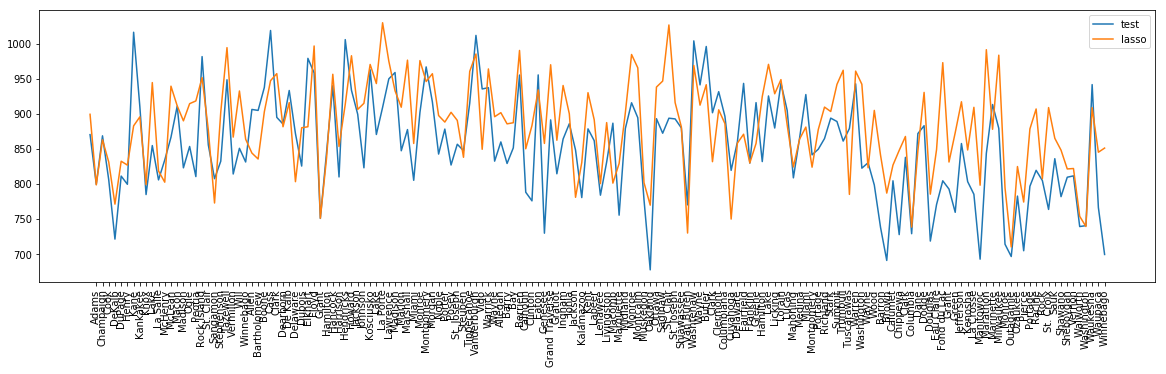

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(20, 5)) 

plt.xticks(range(1, len(df_test['CHSI_County_Name'].values)), df_test['CHSI_County_Name'].values, rotation=90)
plt.plot(y_test, label="test")
plt.plot(lasso.pred, label="lasso")
plt.legend()

from statistics import stdev
print(stdev(y_test))
print(stdev(y_test - lasso.pred))

# 2. Ridge
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV

In [10]:
#### クロスバリデーション実行
ridge = linear_model.RidgeCV(alphas=(0.001, 0.01, 0.1, 1.0, 10.0), cv=kfold_cv) # Ridgeのハイパーパラメータ候補を手入力。
ridge.fit(X_train, y_train)

#### CVの諸設定を出力
print(ridge)

#### クロスバリデーションで得たハイパーパラメータ
print(' ')
print('Ridge alpha is {}'.format(ridge.alpha_))

#### クロスバリデーションで得たパラメータおよびハイパーパラメータをもとに、予測実行
ridge.pred = ridge.predict(X_test)

#### 精度評価
print(' ')
print('R2 is {}'.format(r2_score(y_test, ridge.pred)) )
#print('RMSR is {}'.format(np.sqrt(mean_squared_error(y_test, ridge.pred))) )

RidgeCV(alphas=(0.001, 0.01, 0.1, 1.0, 10.0),
    cv=KFold(n_splits=5, random_state=0, shuffle=True), fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)
 
Ridge alpha is 10.0
 
R2 is 0.247309483243765
RMSR is 63.88038710513861


73.85628163314983
56.904036846795535


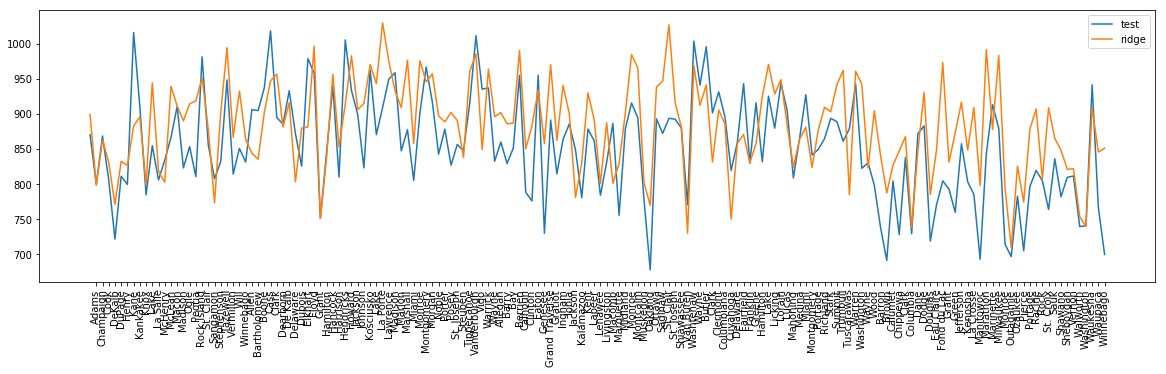

In [62]:
fig, ax = plt.subplots(figsize=(20, 5)) 

plt.xticks(range(1, len(df_test['CHSI_County_Name'].values)), df_test['CHSI_County_Name'].values, rotation=90)
plt.plot(y_test, label="test")
plt.plot(ridge.pred, label="ridge")
plt.legend()

print(stdev(y_test))
print(stdev(y_test - ridge.pred))

# 3. サポートベクターマシン

In [12]:
svr = svm.SVR(kernel='linear')

#### ハイパーパラメータ候補
param_grid = [
    {'C': [0.01, 0.1, 0.5], 'kernel': ['linear']},
#     {'C': [0.01, 0.1, 0.5], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
]

#### クロスバリデーション実行
reg = GridSearchCV(estimator=svr,
                   param_grid=param_grid,
                   cv=kfold_cv,
                   scoring='neg_mean_squared_error',
                   n_jobs=-1,
                   return_train_score=True)
reg.fit(X_train, y_train) 

#### クロスバリデーションで得たハイパーパラメータ
print(reg.best_estimator_)

#### クロスバリデーションで得たパラメータおよびハイパーパラメータをもとに、予測実行
predictor=reg.best_estimator_
svm_pred = predictor.predict(X_test)

#### 精度評価
print(' ')
print('R2 is {}'.format(r2_score(y_test, svm_pred)) )
#print('RMSR is {}'.format(np.sqrt(mean_squared_error(y_test, svm_pred))) )

SVR(C=0.5, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
 
R2 is 0.31438891648419565
RMSR is 60.96747823823558


#### サポートベクターマシンのCVで上位スコアを出したハイパーパラメータを表示
参考：http://www.procrasist.com/entry/10-cross-validation

In [13]:
df = pd.DataFrame(reg.cv_results_)
df.sort_values(by=["rank_test_score"])[["params","mean_test_score","std_test_score","mean_fit_time"]].head()

,params,mean_test_score,std_test_score,mean_fit_time
2,"{'C': 0.5, 'kernel': 'linear'}",-6657.076544,1252.112636,0.126994
1,"{'C': 0.1, 'kernel': 'linear'}",-6662.627172,1278.501331,0.086249
0,"{'C': 0.01, 'kernel': 'linear'}",-6879.055923,1407.549884,0.049534


73.85628163314983
55.74752686803639


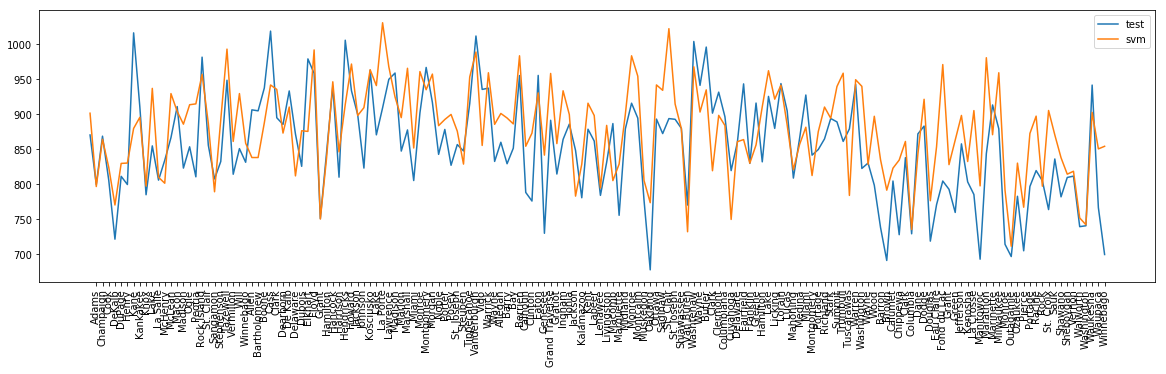

In [63]:
fig, ax = plt.subplots(figsize=(20, 5)) 

plt.xticks(range(1, len(df_test['CHSI_County_Name'].values)), df_test['CHSI_County_Name'].values, rotation=90)
plt.plot(y_test, label="test")
plt.plot(svm_pred, label="svm")
plt.legend()

print(stdev(y_test))
print(stdev(y_test - svm_pred))

# 4. ランダムフォレスト
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor

https://data-science.gr.jp/implementation/iml_sklearn_random_forest.html

In [15]:
rf = RandomForestRegressor(random_state=0)

#### ハイパーパラメータ候補
param_grid = {
    "n_estimators" :[i for i in range(10,200,10)],
    "max_depth"    :[i for i in range(1,10,1)]
    }

#### クロスバリデーション実行
reg = GridSearchCV(estimator=rf,
                   param_grid=param_grid,
                   cv=kfold_cv,
                   scoring='neg_mean_squared_error',
                   n_jobs=-1,
                   return_train_score=True)
reg.fit(X_train, y_train)

#### クロスバリデーションで得たハイパーパラメータ
print(reg.best_estimator_)
    
#### クロスバリデーションで得たパラメータおよびハイパーパラメータをもとに、予測実行
predictor=reg.best_estimator_
rf.pred = predictor.predict(X_test)

#### 精度評価
print(' ')
print('R2 is {}'.format(r2_score(y_test, rf.pred)) )
#print('RMSR is {}'.format(np.sqrt(mean_squared_error(y_test, rf.pred))) )

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=190, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
 
R2 is 0.3789495031302573
RMSR is 58.02601872895809


#### ランダムフォレストのCVで上位スコアを出したハイパーパラメータを表示

In [16]:
df = pd.DataFrame(reg.cv_results_)
df.sort_values(by=["rank_test_score"])[["params","mean_test_score","std_test_score","mean_fit_time"]].head()

,params,mean_test_score,std_test_score,mean_fit_time
132,"{'max_depth': 7, 'n_estimators': 190}",-6795.880271,1154.264950,1.290787
131,"{'max_depth': 7, 'n_estimators': 180}",-6800.936425,1154.686391,1.215670
128,"{'max_depth': 7, 'n_estimators': 150}",-6810.773877,1162.372840,1.088779
120,"{'max_depth': 7, 'n_estimators': 70}",-6812.566202,1144.811153,0.530432
151,"{'max_depth': 8, 'n_estimators': 190}",-6815.500486,1165.816624,1.599628


73.85628163314983
55.39854827904762


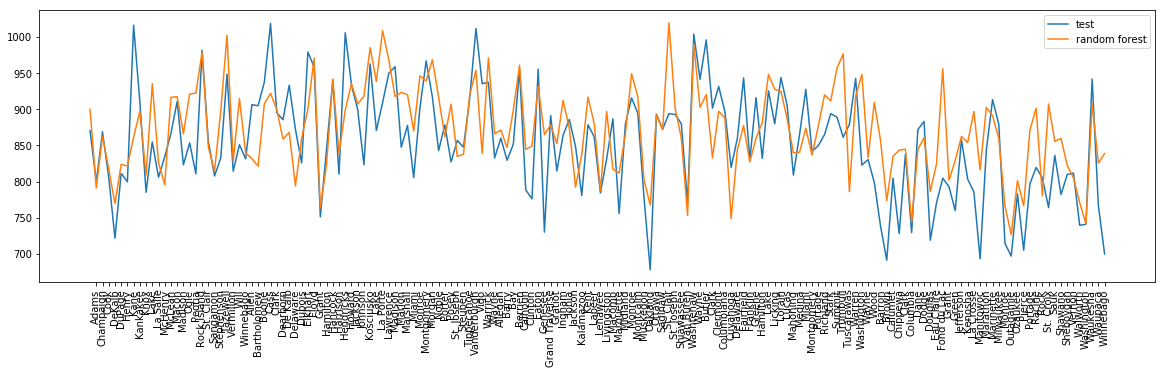

In [65]:
fig, ax = plt.subplots(figsize=(20, 5)) 

plt.xticks(range(1, len(df_test['CHSI_County_Name'].values)), df_test['CHSI_County_Name'].values, rotation=90)
plt.plot(y_test, label="test")
plt.plot(rf.pred, label="random forest")
plt.legend()

print(stdev(y_test))
print(stdev(y_test - rf.pred))

# 5. ブースティング木
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor

https://qiita.com/nazoking@github/items/51a46256ecda598b60dd

In [18]:
gb = GradientBoostingRegressor(random_state=0)

#### ハイパーパラメータ候補
param_grid = {
    "n_estimators" :[i for i in range(10,200,10)],
    "max_depth"    :[i for i in range(1,10,1)]
    }

#### クロスバリデーション実行
reg = GridSearchCV(estimator=gb,
                   param_grid=param_grid,
                   cv=kfold_cv,
                   scoring='neg_mean_squared_error',
                   n_jobs=-1,
                   return_train_score=True)
reg.fit(X_train, y_train)

#### クロスバリデーションで得たハイパーパラメータ
print(reg.best_estimator_)
    
#### クロスバリデーションで得たパラメータおよびハイパーパラメータをもとに、予測実行
predictor=reg.best_estimator_
gb.pred = predictor.predict(X_test)

#### 精度評価
print(' ')
print('R2 is {}'.format(r2_score(y_test, gb.pred)) )
#print('RMSR is {}'.format(np.sqrt(mean_squared_error(y_test, gb.pred))) )

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=80, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False)
 
R2 is 0.34483743803808375
RMSR is 59.598297440821035


#### ブースティング木のCVで上位スコアを出したハイパーパラメータを表示

In [19]:
df = pd.DataFrame(reg.cv_results_)
df.sort_values(by=["rank_test_score"])[["params","mean_test_score","std_test_score","mean_fit_time"]].head()

,params,mean_test_score,std_test_score,mean_fit_time
45,"{'max_depth': 3, 'n_estimators': 80}",-6609.994748,894.533013,0.111587
44,"{'max_depth': 3, 'n_estimators': 70}",-6614.533574,916.282273,0.098003
46,"{'max_depth': 3, 'n_estimators': 90}",-6615.560826,877.890209,0.116916
47,"{'max_depth': 3, 'n_estimators': 100}",-6624.107223,854.718995,0.129641
43,"{'max_depth': 3, 'n_estimators': 60}",-6638.870942,936.533143,0.093973


73.85628163314983
56.49772865502873


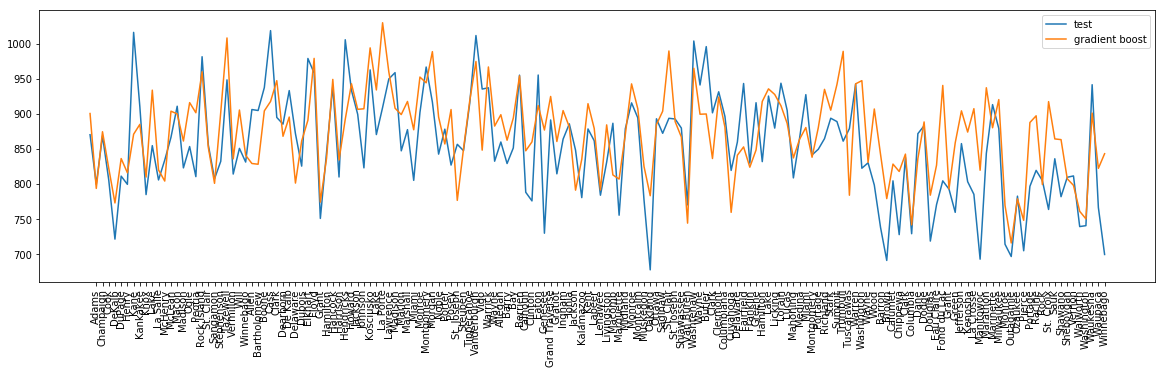

In [67]:
fig, ax = plt.subplots(figsize=(20, 5)) 

plt.xticks(range(1, len(df_test['CHSI_County_Name'].values)), df_test['CHSI_County_Name'].values, rotation=90)
plt.plot(y_test, label="test")
plt.plot(gb.pred, label="gradient boost")
plt.legend()

print(stdev(y_test))
print(stdev(y_test - gb.pred))

# 6. ニューラルネット（多層パーセプトロン）
公式：http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor

シンプルな計算例：https://qiita.com/mix_dvd/items/c37ef06b1ba58bf6d578

丁寧なパラメータ解説：https://data-science.gr.jp/implementation/iml_sklearn_mlp.html

丁寧なパラメータ解説：https://spjai.com/neural-network-parameter/

In [21]:
nnet = MLPRegressor(random_state=0, max_iter=20000) # early_stopping=Trueはすべきか 

#### ハイパーパラメータ候補
param_grid = {
    "hidden_layer_sizes" : [(3), (4), (6), (3, 3), (6, 6)],
    "batch_size" : [20, 50]
    }

#### クロスバリデーション実行
reg = GridSearchCV(estimator=nnet,
                   param_grid=param_grid,
                   cv=kfold_cv,
                   scoring='neg_mean_squared_error',
                   n_jobs=-1,
                   return_train_score=True)
reg.fit(X_train, y_train)

#### クロスバリデーションで得たハイパーパラメータ
print(reg.best_estimator_)
    
#### クロスバリデーションで得たパラメータおよびハイパーパラメータをもとに、予測実行
predictor=reg.best_estimator_
nnet.pred = predictor.predict(X_test)

#### 精度評価
print(' ')
print('R2 is {}'.format(r2_score(y_test, nnet.pred)) )
#print('RMSR is {}'.format(np.sqrt(mean_squared_error(y_test, nnet.pred))) )

MLPRegressor(activation='relu', alpha=0.0001, batch_size=20, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=6, learning_rate='constant',
       learning_rate_init=0.001, max_iter=20000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
 
R2 is 0.24218033284485008
RMSR is 64.0976715066516


#### ニューラルネットのCVで上位スコアを出したハイパーパラメータを表示

In [22]:
df = pd.DataFrame(reg.cv_results_)
df.sort_values(by=["rank_test_score"])[["params","mean_test_score","std_test_score","mean_fit_time"]].head()

,params,mean_test_score,std_test_score,mean_fit_time
2,"{'batch_size': 20, 'hidden_layer_sizes': 6}",-7130.222797,1401.356305,3.126661
1,"{'batch_size': 20, 'hidden_layer_sizes': 4}",-7158.047811,1389.279353,3.653269
7,"{'batch_size': 50, 'hidden_layer_sizes': 6}",-7202.200552,1334.226685,2.827277
6,"{'batch_size': 50, 'hidden_layer_sizes': 4}",-7228.780790,1381.941378,3.114091
5,"{'batch_size': 50, 'hidden_layer_sizes': 3}",-7249.744785,1477.727316,2.189298


73.85628163314983
59.09001752402093


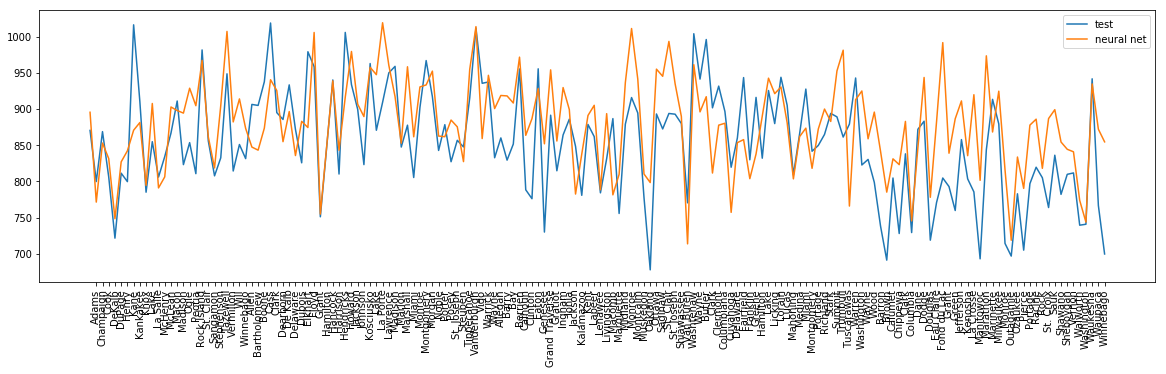

In [68]:
fig, ax = plt.subplots(figsize=(20, 5)) 

plt.xticks(range(1, len(df_test['CHSI_County_Name'].values)), df_test['CHSI_County_Name'].values, rotation=90)
plt.plot(y_test, label="test")
plt.plot(nnet.pred, label="neural net")
plt.legend()

from statistics import stdev
print(stdev(y_test))
print(stdev(y_test - nnet.pred))

# 7. XGBoost
http://tekenuko.hatenablog.com/entry/2016/09/22/220814

https://qiita.com/onlyzs/items/46305d3ca41f0a764b55

In [24]:
xgb_model = xgb.XGBRegressor(random_state=0)

#### ハイパーパラメータ候補
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 0.85, 0.9, 0.95],
    'learning_rate' : [0.05, 0.1, 0.2]
    }

#### クロスバリデーション実行
reg = GridSearchCV(estimator=xgb_model,
                   param_grid=param_grid,
                   cv=kfold_cv,
                   scoring='neg_mean_squared_error', 
                   n_jobs=-1,
                   return_train_score=True)
reg.fit(X_train, y_train)

#### クロスバリデーションで得たハイパーパラメータ
print(reg.best_estimator_)

#### クロスバリデーションで得たパラメータおよびハイパーパラメータをもとに、予測実行
predictor = reg.best_estimator_
xgb_pred = predictor.predict(X_test)

#### 精度評価
print(' ')
print('R2 is {}'.format(r2_score(y_test, xgb_pred)) )
#rint('RMSR is {}'.format(np.sqrt(mean_squared_error(y_test, xgb_pred))) )

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.95)
 
R2 is 0.3925733527074019
RMSR is 57.38603741214849


#### XGBoostのCVで上位スコアを出したハイパーパラメータを表示

In [25]:
pd.set_option("display.max_colwidth", 150)
df = pd.DataFrame(reg.cv_results_)
df.sort_values(by=["rank_test_score"])[["params","mean_test_score","std_test_score"]].head()

,params,mean_test_score,std_test_score
7,"{'learning_rate': 0.05, 'max_depth': 5, 'subsample': 0.95}",-6746.323011,1214.128374
17,"{'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.85}",-6748.600415,1058.487422
16,"{'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8}",-6757.185326,1091.241752
6,"{'learning_rate': 0.05, 'max_depth': 5, 'subsample': 0.9}",-6767.860449,1180.357155
5,"{'learning_rate': 0.05, 'max_depth': 5, 'subsample': 0.85}",-6771.720503,1272.417898


73.85628163314983
55.9282154845265


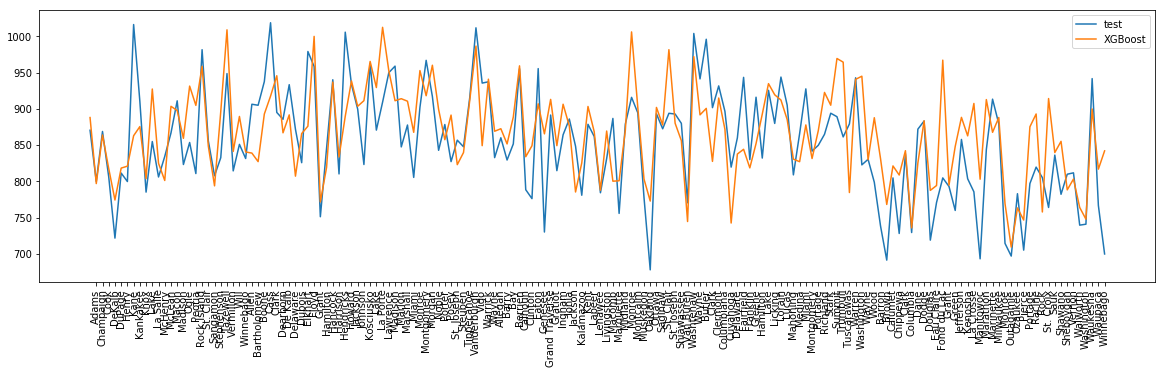

In [69]:
fig, ax = plt.subplots(figsize=(20, 5)) 

plt.xticks(range(1, len(df_test['CHSI_County_Name'].values)), df_test['CHSI_County_Name'].values, rotation=90)
plt.plot(y_test, label="test")
plt.plot(xgb_pred, label="XGBoost")
plt.legend()

print(stdev(y_test))
print(stdev(y_test - xgb_pred))

# 8. LightGBM
https://blog.amedama.jp/entry/2018/05/01/081842

https://stackoverrun.com/ja/q/12370570

http://longtweets.hatenablog.com/?page=1520156276

https://qiita.com/TomokIshii/items/3729c1b9c658cc48b5cb

In [27]:
lgb_model = lgb.LGBMRegressor(random_state=0)

#### ハイパーパラメータ候補
param_grid = {
    'objective' : ['regression'],
    'max_depth': [2, 3, 5, 7],
    'num_leaves' : [2, 4, 8, 31, 32, 128],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators':[100, 200, 400],
    }

#### クロスバリデーション実行
reg = GridSearchCV(estimator=lgb_model,
                   param_grid=param_grid,
                   cv=kfold_cv,
                   scoring='neg_mean_squared_error', # 'mean_squared_error' と書いても同じ。
                   n_jobs=-1,
                   return_train_score=True)
reg.fit(X_train, y_train)

#### クロスバリデーションで得たハイパーパラメータ
print(reg.best_estimator_)
    
#### クロスバリデーションで得たパラメータおよびハイパーパラメータをもとに、予測実行
predictor = reg.best_estimator_
lgb_pred = predictor.predict(X_test)

#### 精度評価
print(' ')
print('R2 is {}'.format(r2_score(y_test, lgb_pred)) )
print('RMSR is {}'.format(np.sqrt(mean_squared_error(y_test, lgb_pred))) )

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=2, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=4, objective='regression', random_state=0,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)
 
R2 is 0.3016612619099428
RMSR is 61.53077482406352


#### LightGBMのCVで上位スコアを出したハイパーパラメータを表示

In [28]:
df = pd.DataFrame(reg.cv_results_)
df.sort_values(by=["rank_test_score"])[["params","mean_test_score","std_test_score"]].head()

,params,mean_test_score,std_test_score
76,"{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'num_leaves': 32, 'objective': 'regression'}",-6889.954721,1100.691656
73,"{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'num_leaves': 4, 'objective': 'regression'}",-6889.954721,1100.691656
74,"{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'num_leaves': 8, 'objective': 'regression'}",-6889.954721,1100.691656
77,"{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'num_leaves': 128, 'objective': 'regression'}",-6889.954721,1100.691656
75,"{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'num_leaves': 31, 'objective': 'regression'}",-6889.954721,1100.691656


73.85628163314983
57.22247571448405


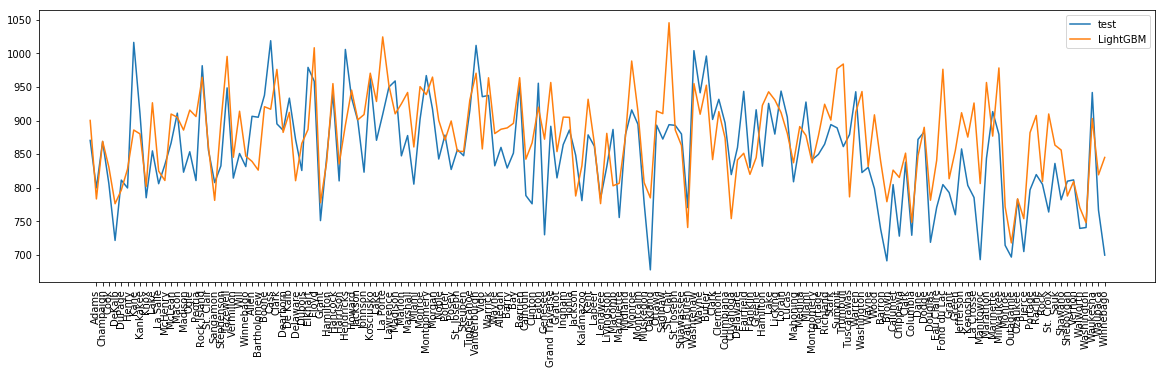

In [70]:
fig, ax = plt.subplots(figsize=(20, 5)) 

plt.xticks(range(1, len(df_test['CHSI_County_Name'].values)), df_test['CHSI_County_Name'].values, rotation=90)
plt.plot(y_test, label="test")
plt.plot(lgb_pred, label="LightGBM")
plt.legend()

print(stdev(y_test))
print(stdev(y_test - lgb_pred))

In [31]:
from statistics import mean